In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from spektral.data.loaders import SingleLoader, DisjointLoader, BatchLoader
from spektral.layers import GATConv, DiffusionConv, GCNConv
from spektral.transforms import LayerPreprocess

from preprocess.extract import generateNNdataMultiple
from preprocess.common import airports_top10, airports_top25, airports_top50
from preprocess.extractadjacency import distance_weight_adjacency

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from preprocess.extract import generalFilterAirport, filterAirports
from tqdm import tqdm

pd.set_option("display.max_columns", None)



In [2]:
%load_ext tensorboard


In [3]:
tf.config.list_physical_devices("GPU")


2022-02-10 23:15:06.561263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 23:15:06.572352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 23:15:06.572959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# removing istanbul airport as it opened in mid-2019
airports = list(filter(lambda x: x != "LTFM", airports_top25))

n_nodes = n_airports = len(airports)

start=datetime(2018, 1, 1)
end=datetime(2019, 12, 31)

timeinterval = 30


## Load Data

In [5]:
data_dict = generateNNdataMultiple(
    airports,
    timeinterval,
    GNNFormat=True,
    start=start,
    end=end,
    forceRegenerateData=False,
)


100%|██████████| 25/25 [00:01<00:00, 23.62it/s]


In [6]:
# randomly split train, test

# np.random.seed(42)
dates = data_dict["EGLL"]["X"].date.sort_values().unique()
# np.random.shuffle(dates)

idx_split = int(len(dates) * 0.80)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]


In [7]:
X_all = pd.concat([d["X"] for ap, d in data_dict.items()]).drop(
    ["date", "timeslot"], axis=1
)
Y_all = pd.concat([d["Y"] for ap, d in data_dict.items()])

scaler = StandardScaler()
scaler.fit(pd.concat([X_all, Y_all], axis=1))


StandardScaler()

In [8]:
X_train_list = []
Y_train_list = []
X_test_list = []
Y_test_list = []


for airport in airports:
    xy = pd.concat([data_dict[airport]["X"], data_dict[airport]["Y"]], axis=1)
    xy_train = xy.query("date in @train_dates")
    xy_test = xy.query("date in @test_dates")

    # train: size T x F
    x_train = xy_train.drop(columns=["timeslot", "date"])
    y_train = xy_train[["arrivalsArrivalDelay", "departuresDepartureDelay"]]
    X_train_list.append(scaler.transform(x_train))
    Y_train_list.append(y_train)

    # test: size T x F
    x_test = xy_test.drop(columns=["timeslot", "date"])
    y_test = xy_test[["arrivalsArrivalDelay", "departuresDepartureDelay"]]
    X_test_list.append(scaler.transform(x_test))
    Y_test_list.append(y_test)

X_train = np.stack(X_train_list)
Y_train = np.stack(Y_train_list)
X_test = np.stack(X_test_list)
Y_test = np.stack(Y_test_list)

# N x T x F
X_train = np.swapaxes(X_train, 0, 1).astype(np.float16)
Y_train = np.swapaxes(Y_train, 0, 1).astype(np.float16)
X_test = np.swapaxes(X_test, 0, 1).astype(np.float16)
Y_test = np.swapaxes(Y_test, 0, 1).astype(np.float16)

print(f"T x N x F: X_train = {X_train.shape} | Y_train = {Y_train.shape}")
print(f"T x N x F: X_test = {X_test.shape} | Y_test = {Y_test.shape}")


T x N x F: X_train = (9312, 25, 11) | Y_train = (9312, 25, 2)
T x N x F: X_test = (2352, 25, 11) | Y_test = (2352, 25, 2)


## Generate Adjacency Matrices

In [9]:
buffer = []

for airport in tqdm(airports):
    # generate filtered data
    df_ap = generalFilterAirport(start, end, airport)
    df_ap = filterAirports(df_ap, airports)
    df_ap = df_ap[["ADEP", "ADES", "FiledOBT", "FiledAT"]]

    buffer.append(df_ap)

df_net = pd.concat(buffer).assign(date=lambda d: d.FiledOBT.dt.date.astype(str))


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


In [11]:
df_net_train = df_net.query("date in @train_dates").drop(columns=["date"])
df_net_test = df_net.query("date in @test_dates").drop(columns=["date"])

# Create a list with all times for multiindex later:
def daterange(start: datetime, end: datetime, date_filter=None):
    """Create list of timeslots."""

    delta = timedelta(minutes=timeinterval)
    time = start
    date_filter = date_filter.astype(str)
    buffer = []
    while time < end:

        ts = time.strftime("%Y-%m-%d")

        if (date_filter is not None) and (ts not in date_filter):
            time += delta
            continue

        if time.month not in [3, 6, 9, 12]:
            time += delta
            continue

        buffer.append(time)
        time += delta

    return buffer


def genAdjXY(df, datetime_list):
    # initial step to get the flights between airports
    grouper = pd.Grouper(key="FiledAT", freq=f"{timeinterval}min")
    df = df.groupby([grouper, "ADES"])["ADEP"].value_counts().unstack(fill_value=0)

    # generate multindex format we want: an adjacency matrix
    adjacencyFormat = pd.MultiIndex.from_product([datetime_list, airports])

    # apply the multindex format and sort the columns by airports list
    df = df.reindex(adjacencyFormat, fill_value=0)[airports]

    # Generate numpy adjacency matrix in 3d format
    mat3d = df.to_numpy().reshape(-1, len(airports), len(airports))

    # Normalise the matrix
    maximum = np.amax(mat3d, axis=0)
    new_maximum = np.where(maximum == 0, 1, maximum)
    final_matrix = np.divide(mat3d, new_maximum)

    return final_matrix


throughput_adj_train = genAdjXY(df_net_train, daterange(start, end, train_dates))
throughput_adj_test = genAdjXY(df_net_test, daterange(start, end, test_dates))

print(throughput_adj_train.shape, throughput_adj_test.shape)


(9312, 25, 25) (2352, 25, 25)


In [12]:
distance_adj = distance_weight_adjacency(airports, threshold=400)


In [13]:
A_train = distance_adj * 0.4 + (1 - 0.4) * throughput_adj_train
A_test = distance_adj * 0.4 + (1 - 0.4) * throughput_adj_test
A_train = A_train.astype(np.float16)
A_test = A_test.astype(np.float16)


#### Custom new TF dataset

In [14]:
# Run settings
batch_size = 64
epochs = 100
patience = 5
lookback = 8
lookahead = 6


In [15]:
def createDataset(
    Features: np.ndarray,
    Adjacencies: np.ndarray,
    Targets: np.ndarray,
    lookback: int,
    lookahead: int,
    batch_size: int = 64,
):

    # make windows
    idx = 0
    F_samples = []
    A_samples = []
    Y_samples = []

    while idx + lookback + lookahead < len(Features):

        # Features
        F_sample = Features[idx : idx + lookback, :, :]
        F_samples.append(F_sample)

        # Adjacencies
        A_sample = Adjacencies[idx : idx + lookback, :, :]
        A_samples.append(A_sample)

        # make labels with multi-horizon
        Y_sample = Targets[idx + lookback : idx + lookback + lookahead, :, :]
        Y_samples.append(Y_sample)

        idx += 1

    features = np.array(F_samples)
    adjacencies = np.array(A_samples)
    labels = np.array(Y_samples)

    # Ensure only complete batches are made (remove incomplete ones)
    batchCutoff = features.shape[0] - (features.shape[0] % batch_size)

    features, adjacencies, labels = (
        features[:batchCutoff, :, :, :],
        adjacencies[:batchCutoff, :, :, :],
        labels[:batchCutoff, :, :, :],
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        ((features, adjacencies), labels)
    ).batch(batch_size)

    ds = tf.data.Dataset.from_generator(lambda: np.arange(100), output_signature=tf.TensorSpec(shape=(), dtype=tf.int32))

    return dataset


train_dataset = createDataset(
    X_train, A_train, Y_train, lookback, lookahead, batch_size=batch_size
)
test_dataset = createDataset(
    X_test, A_test, Y_test, lookback, lookahead, batch_size=batch_size
)

print(train_dataset)
print(test_dataset)


<BatchDataset shapes: (((None, 8, 25, 11), (None, 8, 25, 25)), (None, 6, 25, 2)), types: ((tf.float16, tf.float16), tf.float16)>
<BatchDataset shapes: (((None, 8, 25, 11), (None, 8, 25, 25)), (None, 6, 25, 2)), types: ((tf.float16, tf.float16), tf.float16)>


2022-02-10 23:21:19.450648: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 23:21:19.451311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 23:21:19.451775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 23:21:19.452218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

## GNN Model

In [16]:
l2_reg = 2.5e-4
channels = 10
attn_heads = 10
lstm_units = 60
num_labels = 2
nFeatures = X_train.shape[2]

x_in = layers.Input(
    shape=(lookback, n_nodes, nFeatures), batch_size=batch_size, name="Features"
)
a_in = layers.Input(
    shape=(lookback, n_nodes, n_nodes), batch_size=batch_size, name="Adjacencies"
)

x_inn = tf.reshape(x_in, (batch_size * lookback, n_airports, nFeatures))
a_inn = tf.reshape(a_in, (batch_size * lookback, n_airports, n_airports))

gatout = GATConv(
    channels=channels,
    attn_heads=attn_heads,
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
    name=f"GAT",
)([x_inn, a_inn])
print(gatout.shape)

reshape1 = tf.reshape(gatout, (batch_size, lookback, n_airports, attn_heads * channels))
print(reshape1.shape)
reshape1 = tf.transpose(reshape1, [0, 2, 1, 3])
print(reshape1.shape)
reshape1 = tf.reshape(
    reshape1, (batch_size * n_airports, lookback, attn_heads * channels)
)
print(reshape1.shape)


lstm1 = layers.LSTM(lstm_units, return_sequences=True, name="LSTM1")(reshape1)
lstm2 = layers.LSTM(lstm_units, return_sequences=False, name="LSTM2")(lstm1)
print(lstm2.shape)
dense1 = layers.Dense(lstm_units, name="Dense1")(lstm2)
print(dense1.shape)
dense2 = layers.Dense(num_labels * lookahead, name="DenseFinal")(dense1)
print(dense2.shape)

output = tf.reshape(
    dense2, (batch_size, n_nodes, lookahead, num_labels), name="ReshapeFinal"
)
# output = tf.reshape(dense2, (n_nodes, batch_size, lookahead, num_labels), name="ReshapeFinal")
print(output.shape)
output = tf.transpose(output, [0, 2, 1, 3], name="Re-orderToOutput")
# output = tf.transpose(output, [1, 2, 0, 3], name="Re-orderToOutput")
print(output.shape)


(512, 25, 100)
(64, 8, 25, 100)
(64, 25, 8, 100)
(1600, 8, 100)
(1600, 60)
(1600, 60)
(1600, 12)
(64, 25, 6, 2)
(64, 6, 25, 2)


In [17]:
model = keras.Model(inputs=[x_in, a_in], outputs=output, name="Tristan")

# optimizer = Adam(learning_rate=learning_rate*10)
optimizer = Adam()
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_squared_error"),
    # weighted_metrics=["acc"],
)

model.summary()
# plot_model(model, to_file='model.png')


Model: "Tristan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features (InputLayer)          [(64, 8, 25, 11)]    0           []                               
                                                                                                  
 Adjacencies (InputLayer)       [(64, 8, 25, 25)]    0           []                               
                                                                                                  
 tf.reshape (TFOpLambda)        (512, 25, 11)        0           ['Features[0][0]']               
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (512, 25, 25)        0           ['Adjacencies[0][0]']            
                                                                                            

In [18]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=learning_rate)

print(train_dataset.element_spec)

es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=patience)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[
        es,
        # tensorboard_callback,
        # reduceLR
    ],
    shuffle=False,
)


((TensorSpec(shape=(None, 8, 25, 11), dtype=tf.float16, name=None), TensorSpec(shape=(None, 8, 25, 25), dtype=tf.float16, name=None)), TensorSpec(shape=(None, 6, 25, 2), dtype=tf.float16, name=None))
Epoch 1/100
  1/145 [..............................] - ETA: 6:23 - loss: 161.3303

2022-02-10 23:21:23.966195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605


145/145 [==============================] - 20s 121ms/step - loss: 66.6198 - val_loss: 55.6357
Epoch 2/100
145/145 [==============================] - 17s 117ms/step - loss: 54.8073 - val_loss: 50.0963
Epoch 3/100
145/145 [==============================] - 17s 117ms/step - loss: 52.4989 - val_loss: 48.7185
Epoch 4/100
145/145 [==============================] - 17s 117ms/step - loss: 51.7016 - val_loss: 48.0273
Epoch 5/100
145/145 [==============================] - 17s 117ms/step - loss: 50.9699 - val_loss: 47.5042
Epoch 6/100
145/145 [==============================] - 17s 117ms/step - loss: 50.3986 - val_loss: 47.1467
Epoch 7/100
145/145 [==============================] - 17s 117ms/step - loss: 49.9656 - val_loss: 46.8642
Epoch 8/100
145/145 [==============================] - 17s 117ms/step - loss: 49.5905 - val_loss: 46.6720
Epoch 9/100
145/145 [==============================] - 17s 117ms/step - loss: 49.2876 - val_loss: 46.5290
Epoch 10/100
145/145 [==============================] - 17

# Analysis


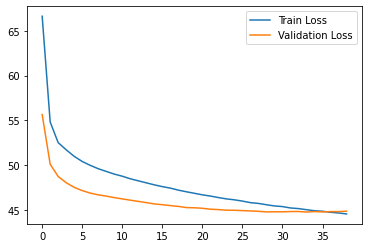

In [19]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [20]:
Y_pred = model.predict(test_dataset)


In [21]:
buffer = []

for i, airport in enumerate(airports):
    xy = pd.concat([data_dict[airport]["X"], data_dict[airport]["Y"]], axis=1)
    xy_test = xy.query("date in @test_dates").iloc[lookback:]

    # Test delay metric, column represent lookahead time
    arr_delay = Y_test[lookback:, i, 0]
    n_row = len(arr_delay)-lookahead
    arr_delays = np.empty((n_row, lookahead))
    for k in range(lookahead):
        arr_delays[:, k] = arr_delay[k:k+n_row]

    dep_delay = Y_test[lookback:, i, 1]
    n_row = len(dep_delay)-lookahead
    dep_delays = np.empty((n_row, lookahead))
    for k in range(lookahead):
        dep_delays[:, k] = dep_delay[k:k+n_row]

    airport_delays = pd.concat(
        [
            pd.DataFrame().assign(time=xy_test['timeslot'].values),

            pd.DataFrame(
                arr_delays.round().astype(int),
                columns=[f"arr_{30*n}m" for n in range(1, lookahead+1)],
            ),

            pd.DataFrame(
                dep_delays.round().astype(int),
                columns=[f"dep_{30*n}m" for n in range(1, lookahead+1)],
            ),

            pd.DataFrame(
                Y_pred[:, :, i, 0].round().astype(int),
                columns=[f"arr_est_{30*n}m" for n in range(1, lookahead+1)],
            ),
            pd.DataFrame(
                Y_pred[:, :, i, 1].round().astype(int),
                columns=[f"dep_est_{30*n}m" for n in range(1, lookahead+1)],
            ),
        ],
        axis=1,
    ).dropna().assign(airport=airport)

    buffer.append(airport_delays)

results = pd.concat(buffer, ignore_index=True)

In [22]:
results.head()

,time,arr_30m,arr_60m,arr_90m,arr_120m,arr_150m,arr_180m,dep_30m,dep_60m,dep_90m,dep_120m,dep_150m,dep_180m,arr_est_30m,arr_est_60m,arr_est_90m,arr_est_120m,arr_est_150m,arr_est_180m,dep_est_30m,dep_est_60m,dep_est_90m,dep_est_120m,dep_est_150m,dep_est_180m,airport
0,2019-09-12 04:00:00,28.0,29.0,27.0,23.0,18.0,21.0,0.0,0.0,0.0,1.0,4.0,2.0,20.0,19.0,17.0,15.0,14.0,14.0,1.0,3.0,4.0,5.0,5.0,5.0,EGLL
1,2019-09-12 04:30:00,29.0,27.0,23.0,18.0,21.0,19.0,0.0,0.0,1.0,4.0,2.0,3.0,22.0,20.0,18.0,17.0,17.0,17.0,2.0,3.0,4.0,5.0,4.0,5.0,EGLL
2,2019-09-12 05:00:00,27.0,23.0,18.0,21.0,19.0,22.0,0.0,1.0,4.0,2.0,3.0,0.0,18.0,17.0,17.0,18.0,19.0,19.0,2.0,3.0,3.0,3.0,3.0,4.0,EGLL
3,2019-09-12 05:30:00,23.0,18.0,21.0,19.0,22.0,26.0,1.0,4.0,2.0,3.0,0.0,1.0,18.0,19.0,20.0,21.0,22.0,22.0,1.0,2.0,3.0,3.0,4.0,4.0,EGLL
4,2019-09-12 06:00:00,18.0,21.0,19.0,22.0,26.0,22.0,4.0,2.0,3.0,0.0,1.0,-1.0,20.0,21.0,23.0,24.0,24.0,24.0,0.0,2.0,3.0,4.0,5.0,6.0,EGLL


In [23]:
results.to_csv("data/network_delay_gnn_results.csv", index=False)


In [24]:
df = results.query('airport == "EGLL"')

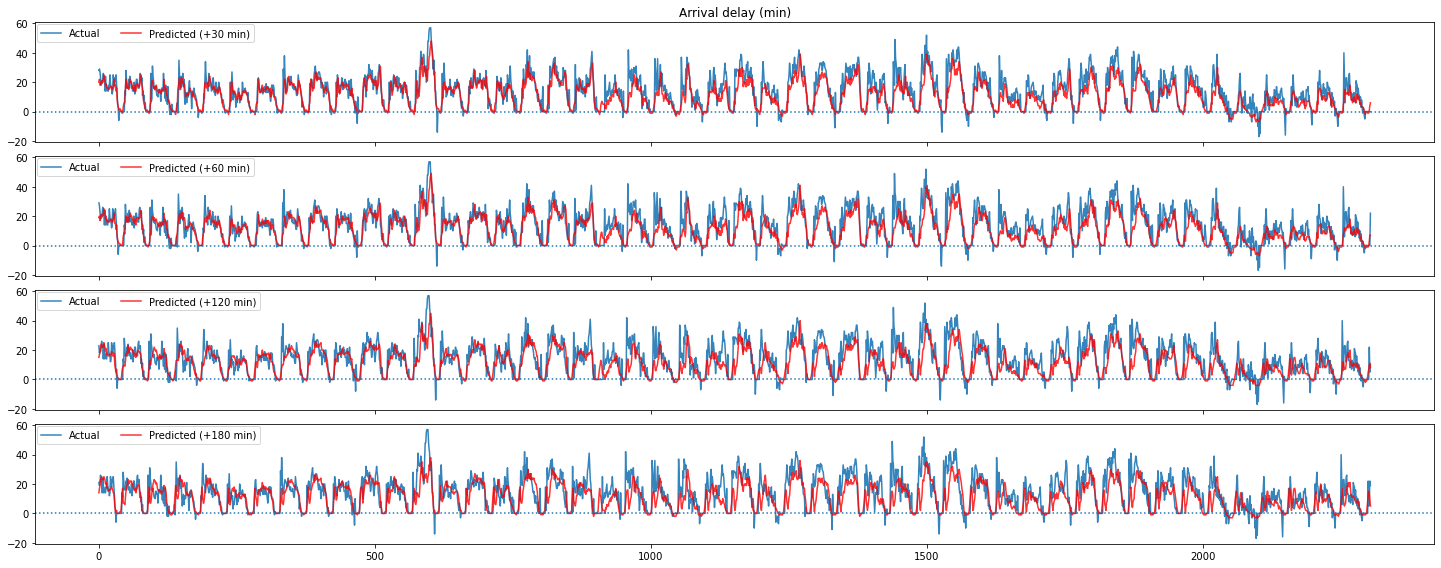

In [25]:

fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.arr_30m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Arrival delay (min)")


ax = axes[1]
ax.plot(df.arr_60m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.arr_120m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.arr_180m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

plt.tight_layout()



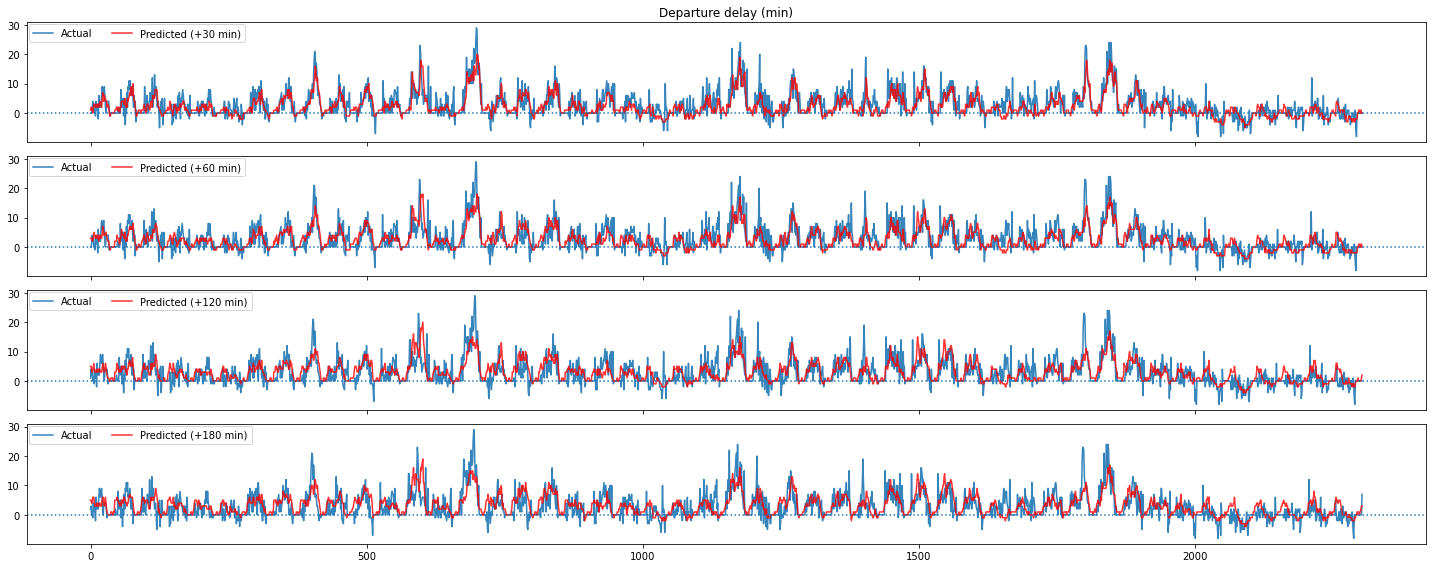

In [27]:
fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.dep_30m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Departure delay (min)")


ax = axes[1]
ax.plot(df.dep_60m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.dep_120m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.dep_180m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

plt.tight_layout()